*@rtbins*

# Amazon stock analysis and predictions

In [1]:
import sys
sys.path.insert(0, "../..")

import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from deepstocks.notebook import psource

### Following class represents various configurations for the model.

In [2]:
from deepstocks.common_configs import RNNConfig, Stock_names, Features

psource(RNNConfig)
psource(Stock_names)
psource(Features)                                                          

cell_type = 'gru'
config = RNNConfig('amazon', cell_type)

stock_names = Stock_names()
features = Features()

def plot_name(name, isPrediction = False):
    if isPrediction:
        return '../../images/{}/{}_{}.png'.format(cell_type, config.stock_name.title(), name)
    return '../../images/{}_{}.png'.format(config.stock_name.title(), name)

### Date exploration
Below we load the data from csv file by providing a date range and stock name

In [3]:
# set a date range 
import datetime
from deepstocks.data_loader import get_csv_data

start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2015, 1, 1)

df = get_csv_data(stock_names.to_symbol[config.stock_name], start_date, end_date, config.window)

df.info()
df.head(15)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2010-01-04 to 2014-12-31
Data columns (total 3 columns):
Adj Close       1258 non-null float64
Volume          1258 non-null float64
Rolling mean    1248 non-null float64
dtypes: float64(3)
memory usage: 79.3 KB


,Adj Close,Volume,Rolling mean
2010-01-04,133.899994,1.000000,NaN
2010-01-05,134.690002,1.164739,NaN
2010-01-06,132.250000,0.944591,NaN
2010-01-07,130.000000,1.451361,NaN
2010-01-08,133.520004,1.293504,NaN
2010-01-11,130.309998,1.155199,NaN
2010-01-12,127.349998,1.196897,NaN
2010-01-13,129.110001,1.410966,NaN
2010-01-14,127.349998,1.286188,NaN
2010-01-15,127.139999,2.023250,NaN


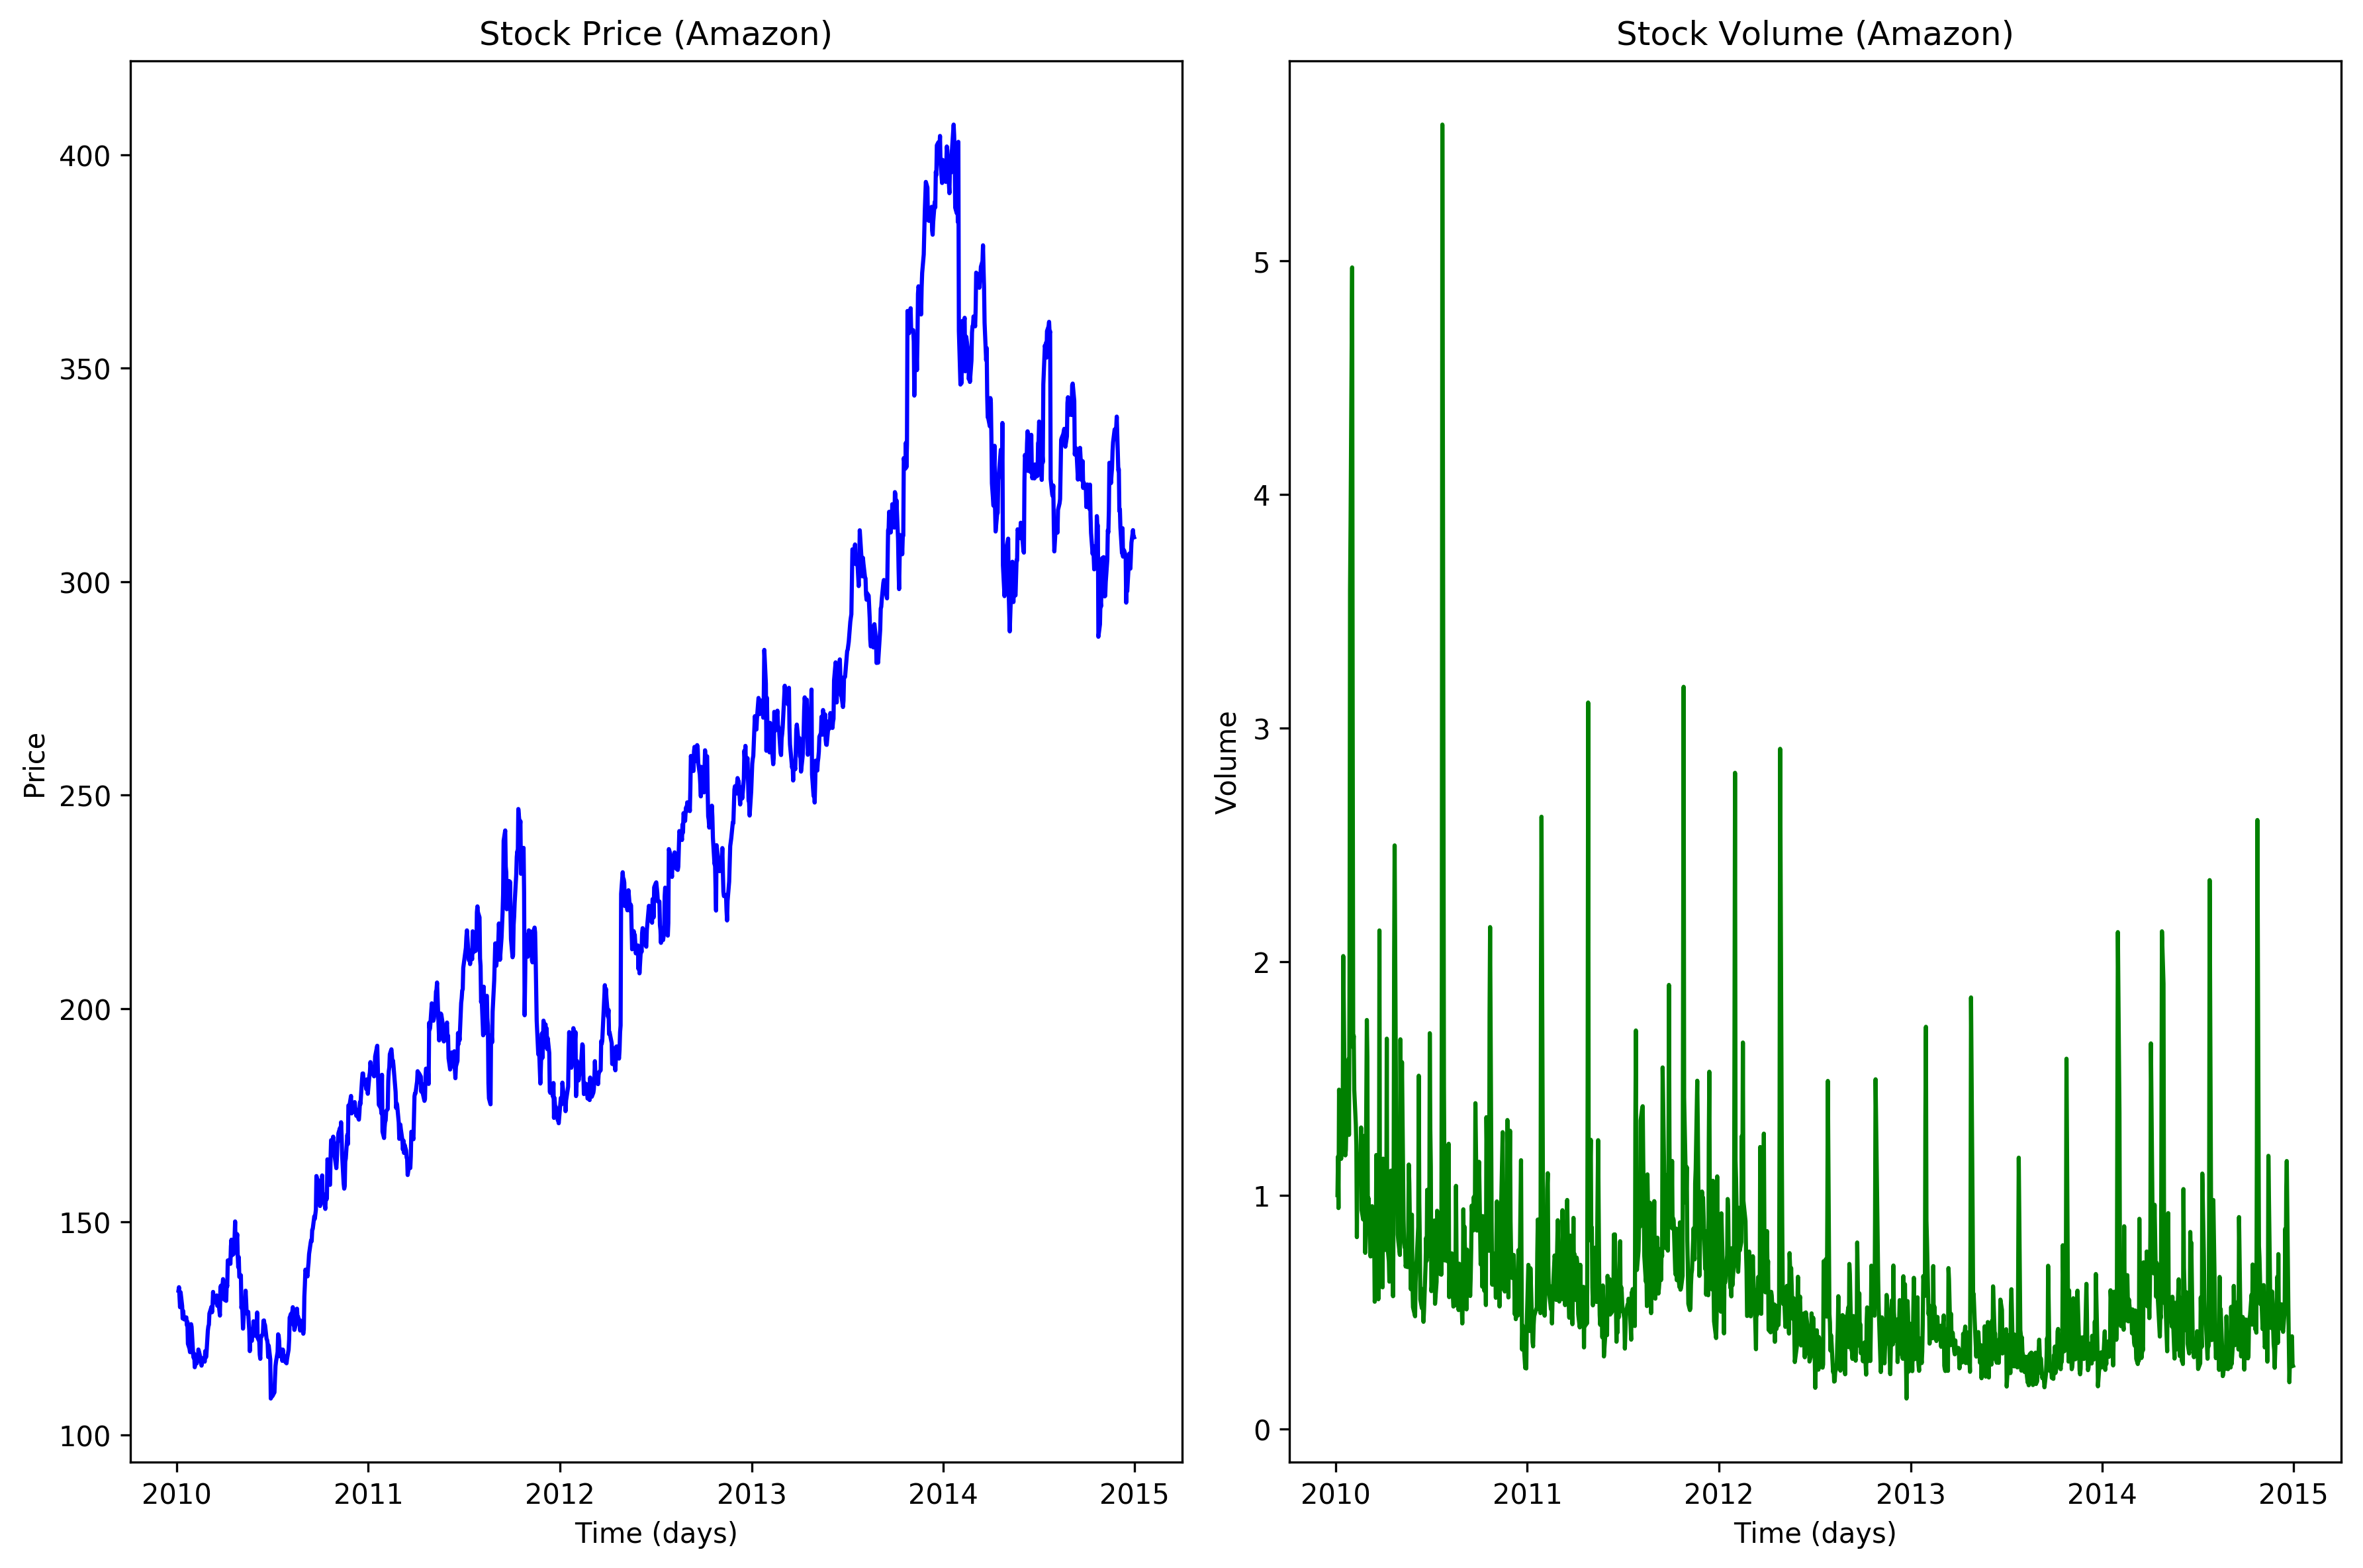

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from deepstocks.visualize import multiple_plots

fig, axes = plt.subplots(figsize=(12,8), nrows=1, ncols=2, dpi=300)

fig_dict = [
    {
        'col':features.adj,
        'color': 'blue',
        'label': features.adj,
        'title': 'Stock Price ({})'.format(config.stock_name.title()),
        'xlabel': 'Time (days)',
        'ylabel': 'Price'
    },
    {
        'col':'Volume',
        'color': 'green',
        'label': 'Volume',
        'title': 'Stock Volume ({})'.format(config.stock_name.title()),
        'xlabel': 'Time (days)',
        'ylabel': 'Volume'
    }
]

multiple_plots(axes, df, fig_dict)

fig.savefig(plot_name('price_volume'))

plt.tight_layout()

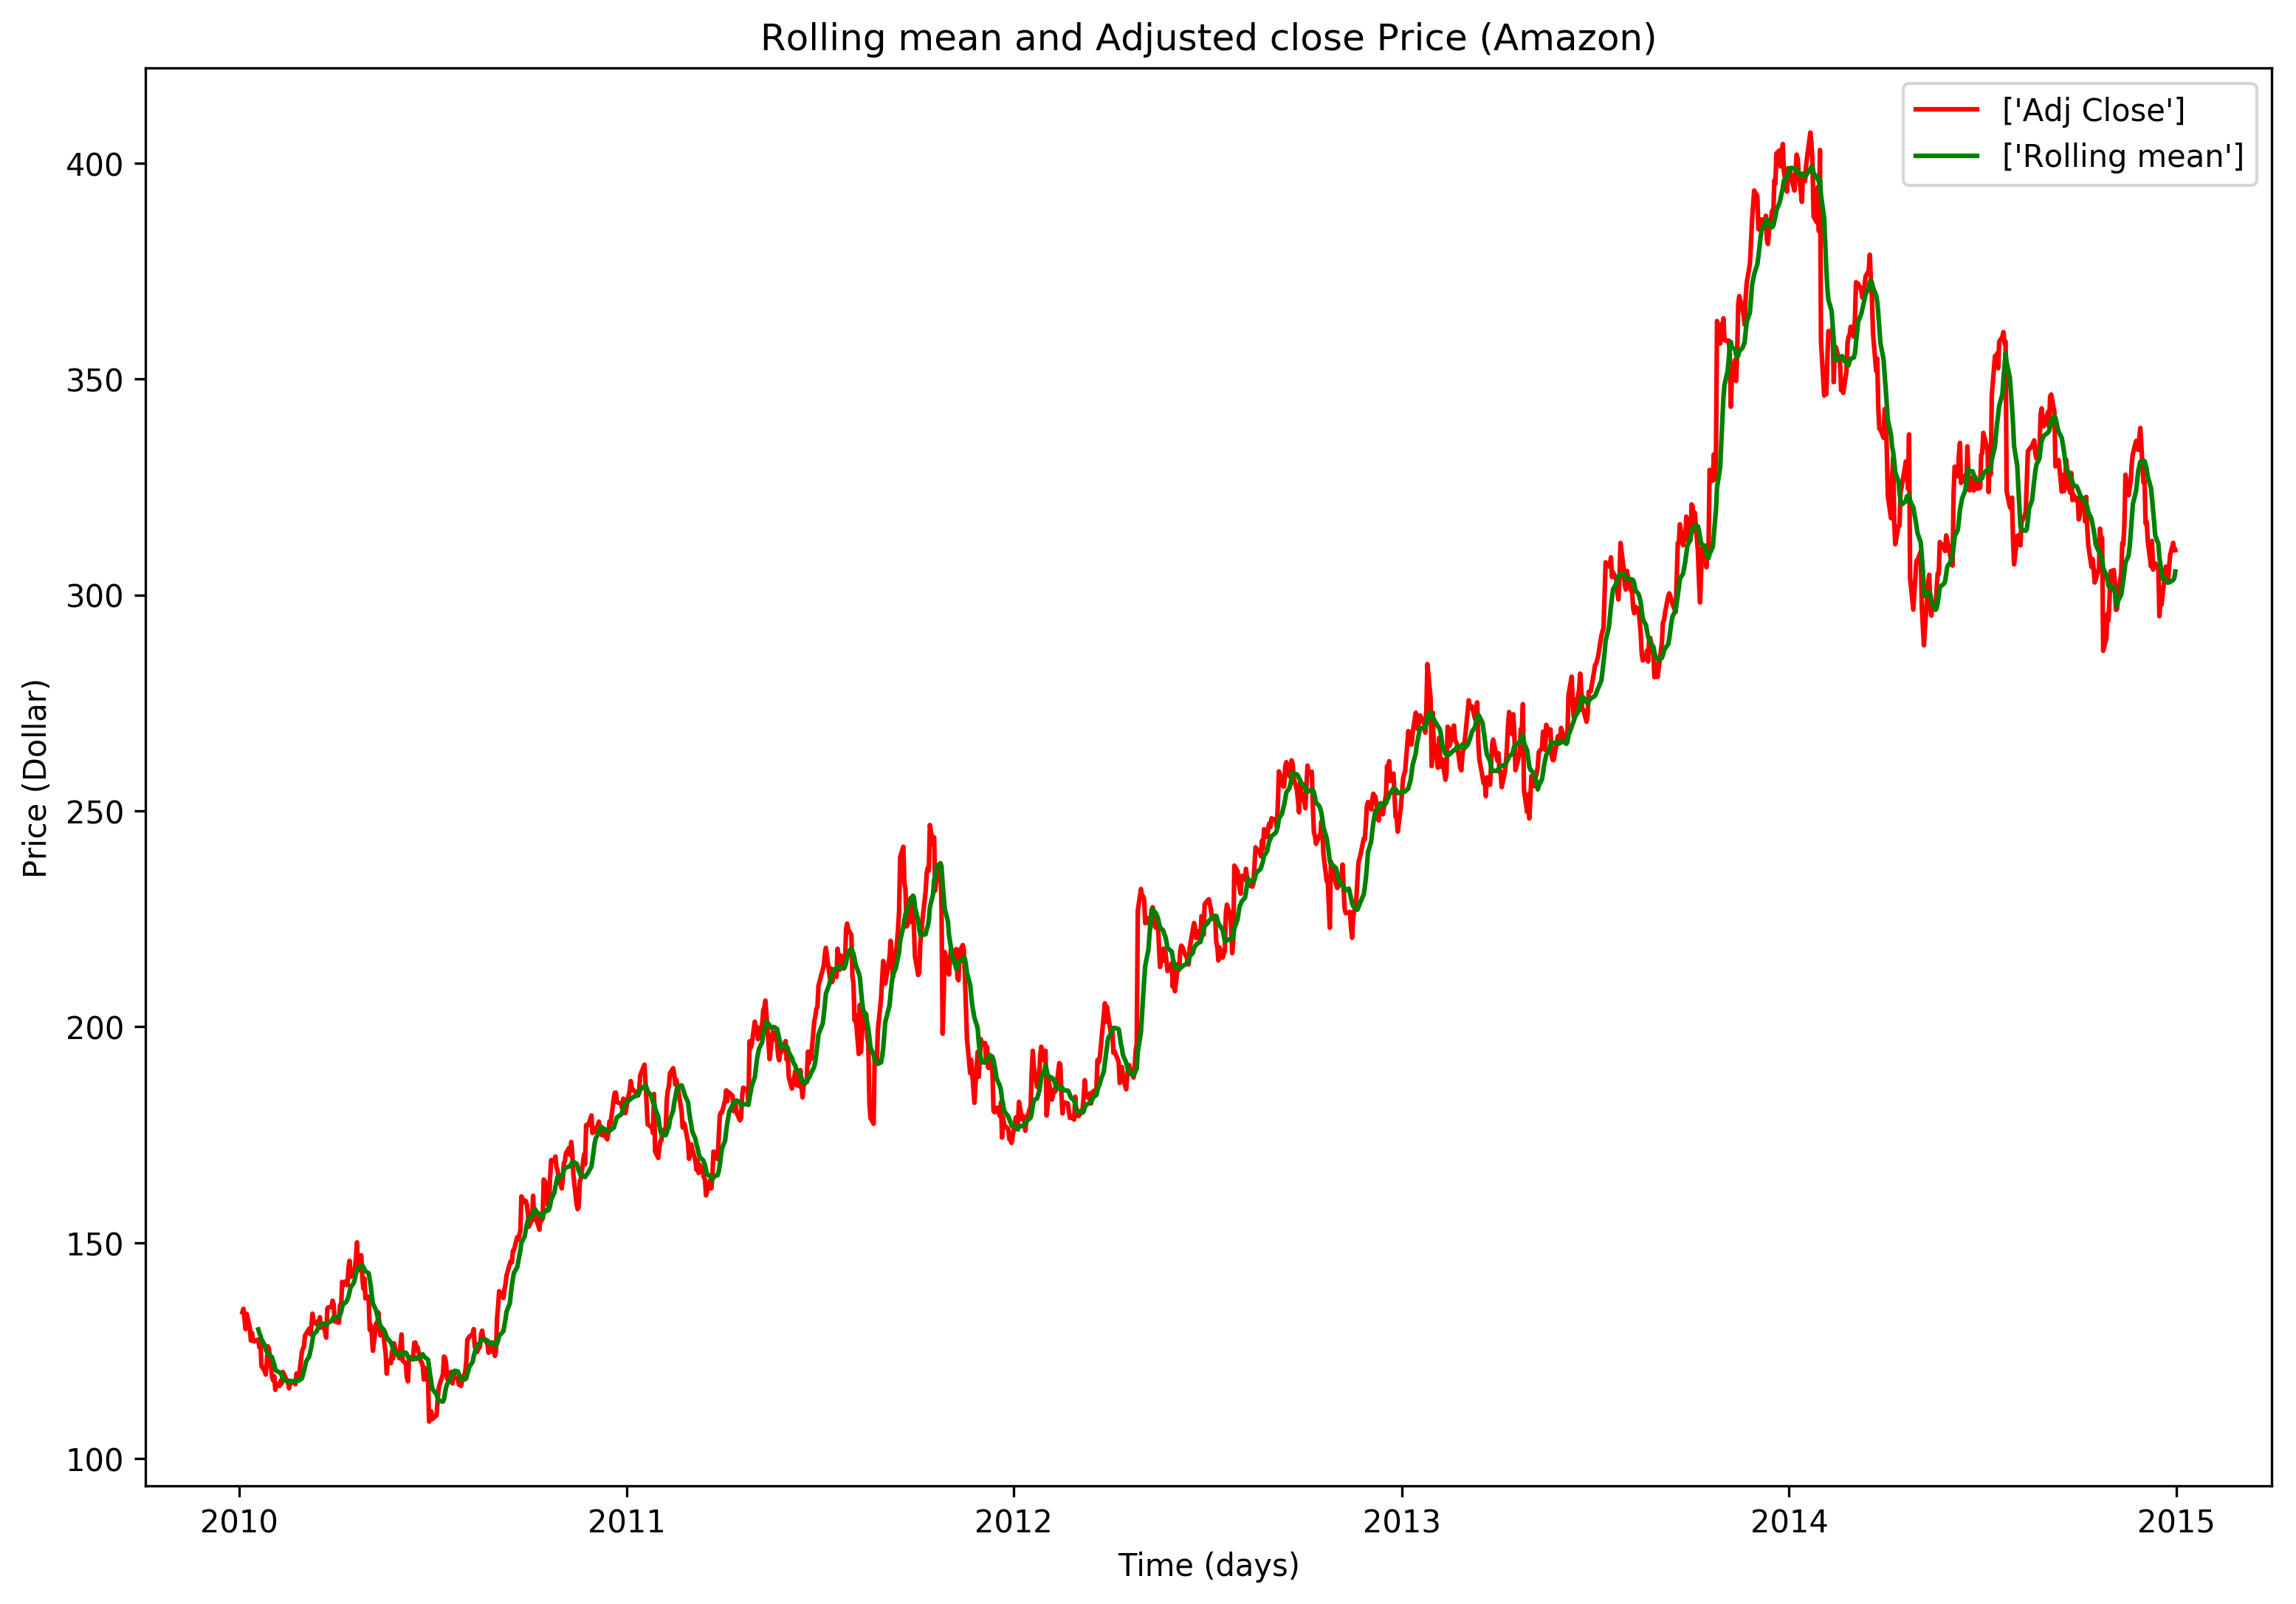

In [5]:
# create a function to plot, with an option of subplots
from deepstocks.visualize import single_figure_plot

plot = plt.figure(figsize=(12,8), dpi=300)
axes = plot.add_axes([0.1, 0.1, 0.8, 0.8])
single_figure_plot(axes, df, cols=[(features.adj, 'red'), (features.rol, 'green')], title = 'Rolling mean and Adjusted close Price ({})'.format(config.stock_name.title()))

plot.savefig(plot_name('price_rolling_mean'))

### Prepare the data

? Importance of normalization

In [6]:
from deepstocks.preprocess import normalize, prepare_data

seq_len = 20
df_stock = df.copy()

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize(df_stock_norm, [features.adj, features.rol], features.rol, config.window)

# create train, test, valid data
x_train, y_train, x_valid, y_valid, x_test, y_test = prepare_data(df_stock_norm, 
                                                                  config.seq_len, 
                                                                  config.valid_ratio, 
                                                                  config.test_ratio)

data = prepare_data(df_stock_norm, config.seq_len, config.valid_ratio, config.test_ratio)

# print a summary
print('df_stock.columns.values : {}\n'.format(df_stock.columns.values))
print('Df shape      : {}'.format( df_stock_norm.shape))
print('x_train shape : {}'.format( x_train.shape))
print('y_train shape : {}'.format( y_train.shape))
print('x_valid shape : {}'.format( x_valid.shape))
print('y_valid shape : {}'.format( y_valid.shape))
print('x_test shape  : {}'.format( x_test.shape))
print('y_test shape  : {}'.format( y_test.shape))

df_stock.columns.values : ['Adj Close' 'Volume' 'Rolling mean']

Df shape      : (1248, 2)
x_train shape : (860, 19, 2)
y_train shape : (860, 2)
x_valid shape : (184, 19, 2)
y_valid shape : (184, 2)
x_test shape  : (184, 19, 2)
y_test shape  : (184, 2)


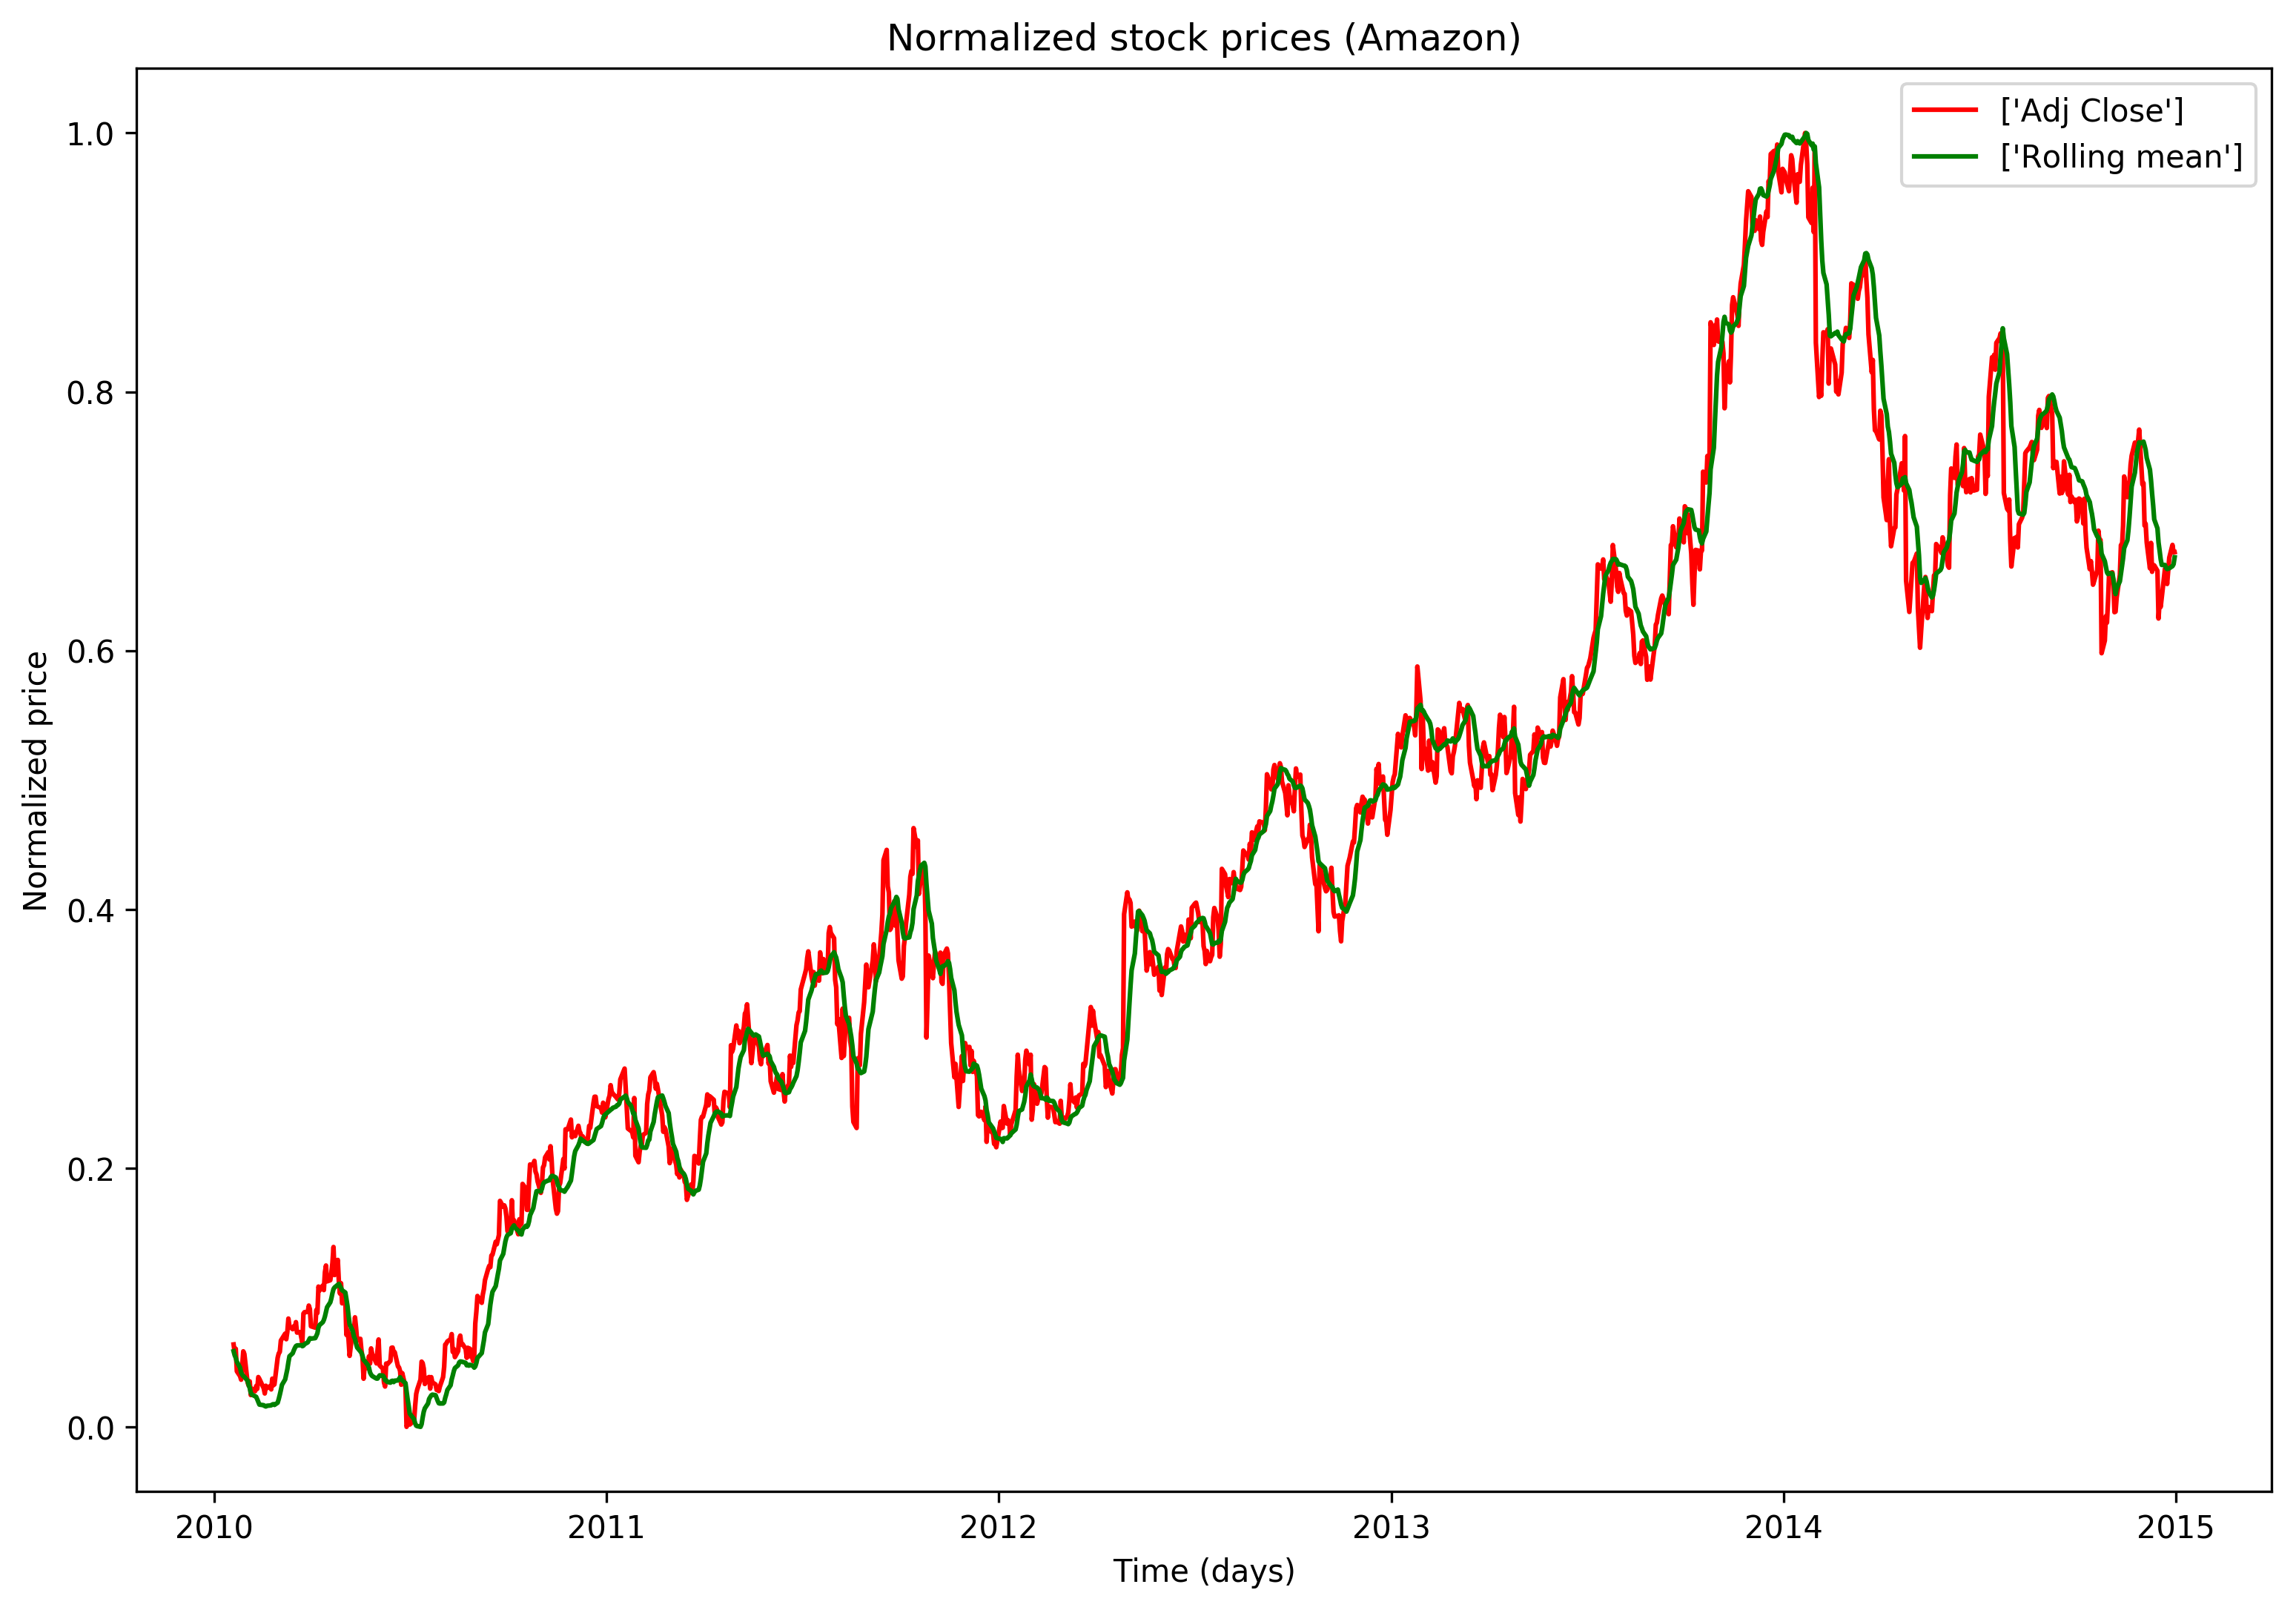

In [7]:
plot_norm = plt.figure(figsize=(12,8), dpi=300)
axes_norm = plot_norm.add_axes([0.1, 0.1, 0.8, 0.8])
single_figure_plot(axes_norm, df_stock_norm, 
                   cols=[(features.adj, 'red'), (features.rol, 'green')], 
                   title= 'Normalized stock prices ({})'.format(config.stock_name.title()),
                   ylabel= 'Normalized price'
                  )

plot_norm.savefig(plot_name('normalized_plot'))

In [8]:
from lstm_train import train_rnn
from lstm_test import test_model
from lstm_predict import predict


psource(train_rnn)

In [9]:
psource(predict)

In [10]:
psource(test_model)

In [11]:
train_rnn(config, features, data)


Epochs : 5,  Mean square error train/valid = 0.103212/0.584070
Epochs : 9,  Mean square error train/valid = 0.001826/0.008944
Epochs : 14,  Mean square error train/valid = 0.001645/0.007411
Epochs : 19,  Mean square error train/valid = 0.001808/0.008819
Epochs : 24,  Mean square error train/valid = 0.001624/0.008550
Epochs : 29,  Mean square error train/valid = 0.001730/0.008442
Epochs : 34,  Mean square error train/valid = 0.001705/0.008299
Epochs : 39,  Mean square error train/valid = 0.001706/0.008855
Epochs : 44,  Mean square error train/valid = 0.002089/0.009341
Epochs : 49,  Mean square error train/valid = 0.001989/0.009609
Epochs : 54,  Mean square error train/valid = 0.001863/0.009933
Epochs : 59,  Mean square error train/valid = 0.002114/0.010218
Epochs : 64,  Mean square error train/valid = 0.002131/0.009825


# Testing accuracy


* data[4] = x_test
* data[5] = y_test

In [12]:
test_model(data[4], data[5], config)

INFO:tensorflow:Restoring parameters from /home/machine/Documents/Capstone-MachineLearning-Nanodegree/Project/checkpoints/gru/forecast_model__amazon
Testing Accuracy: 99.99404511239845 %



# Prediction time

* data[0] = x_train
* data[2] = x_valid
* data[4] = x_test


In [13]:
data.append(predict(config, data[0]))
data.append(predict(config, data[4]))
data.append(predict(config, data[2]))

INFO:tensorflow:Restoring parameters from /home/machine/Documents/Capstone-MachineLearning-Nanodegree/Project/checkpoints/gru/forecast_model__amazon
INFO:tensorflow:Restoring parameters from /home/machine/Documents/Capstone-MachineLearning-Nanodegree/Project/checkpoints/gru/forecast_model__amazon
INFO:tensorflow:Restoring parameters from /home/machine/Documents/Capstone-MachineLearning-Nanodegree/Project/checkpoints/gru/forecast_model__amazon


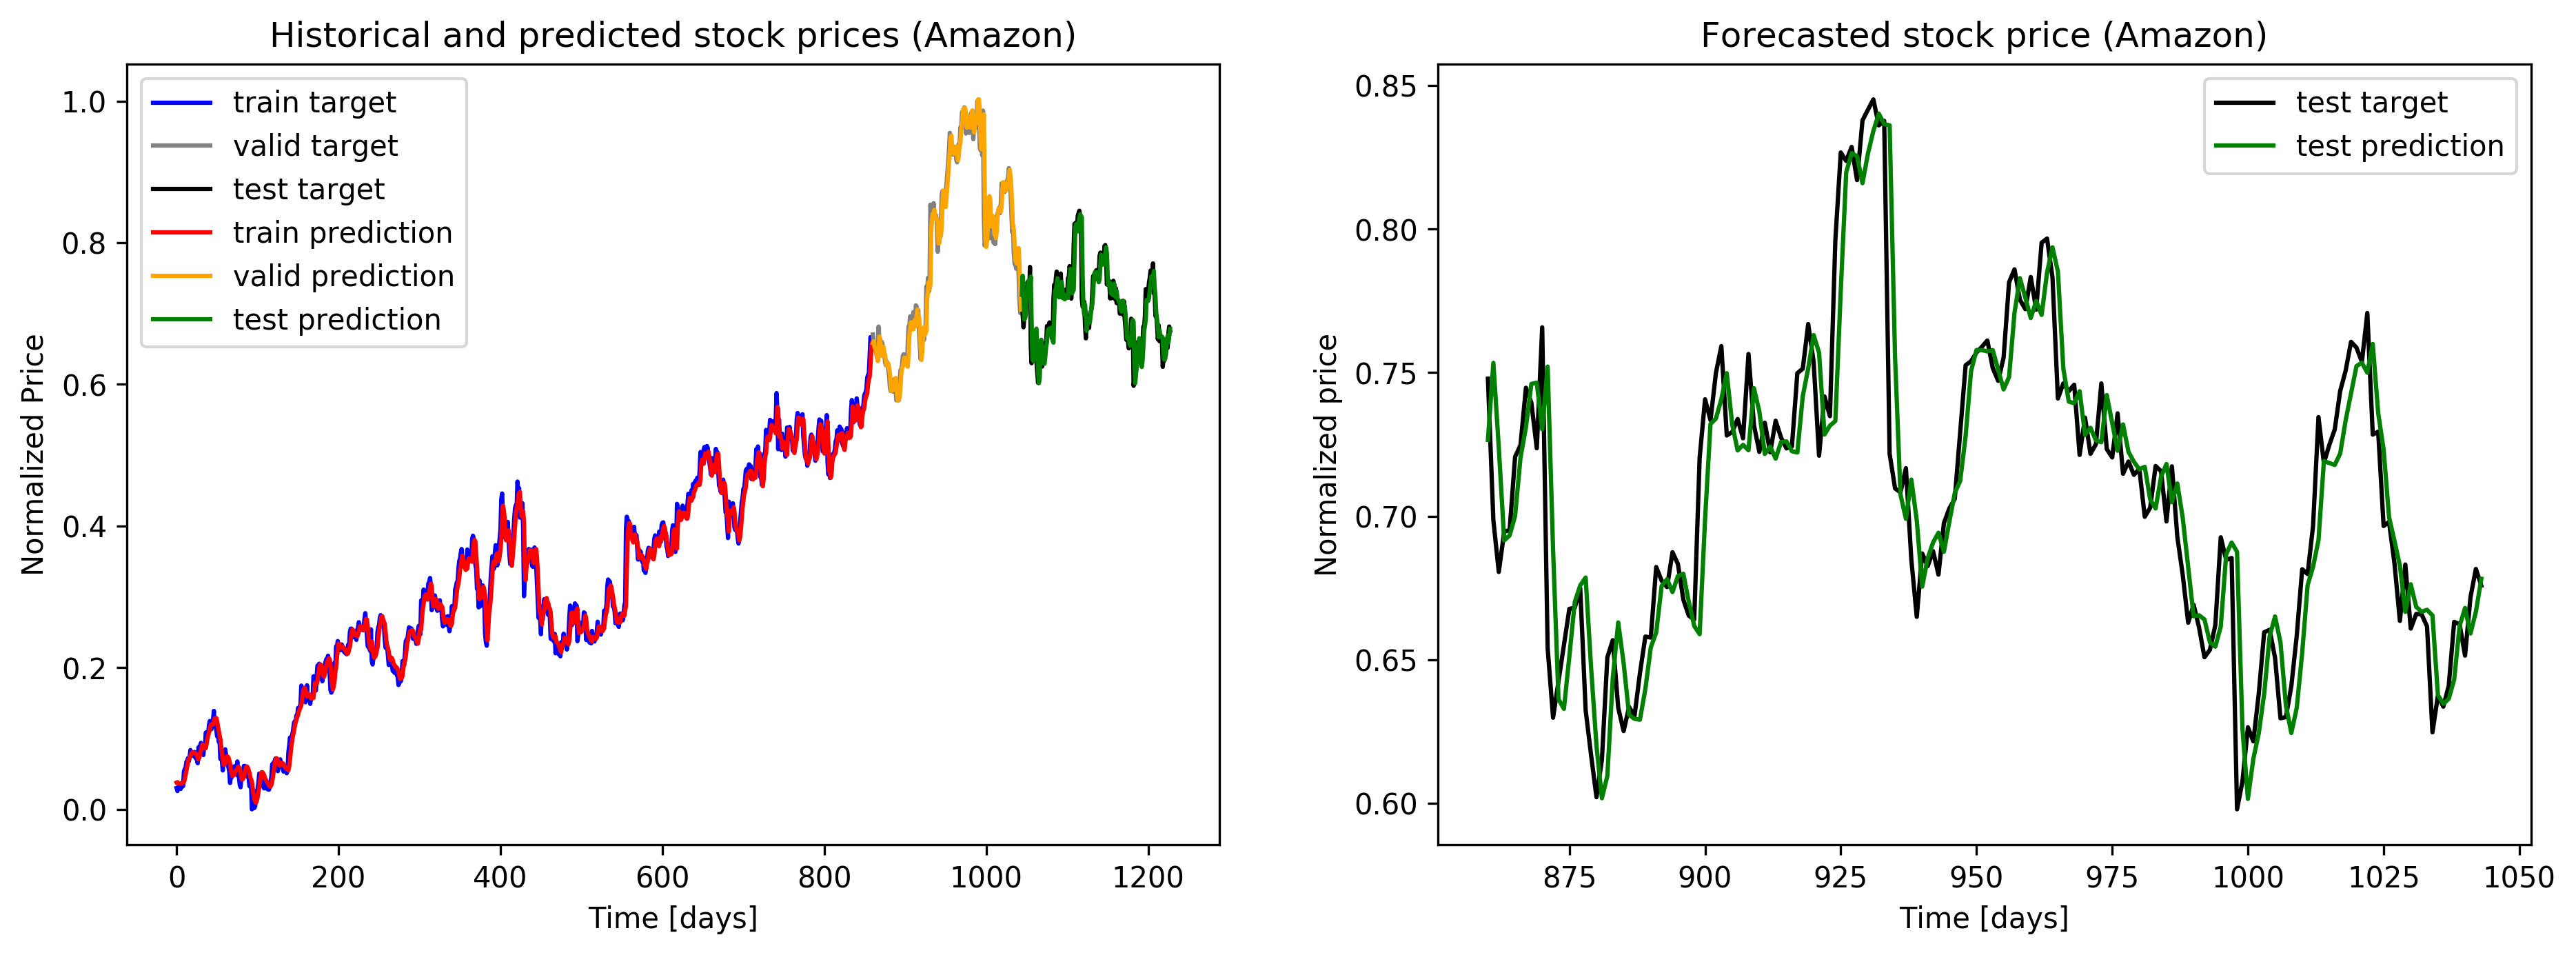

<Figure size 432x288 with 0 Axes>

In [14]:
from deepstocks.visualize import plot_predictions

fig, axes = plt.subplots(figsize=(15,5), nrows=1, ncols=2, dpi=300)
plot_predictions(axes, data, config.stock_name.title())
plt.show()
plt.tight_layout()
fig.savefig(plot_name('prediction_comparison', True))